# YOLO V1 face detector

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## dependencies:

In [2]:
import os, shutil
import xml.etree.ElementTree as ET
import cv2
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision
import numpy as np
import PIL
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
import tensorflow as tf
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import io
import html
import time
from PIL import Image
from keras.utils import np_utils
%matplotlib inline

## download file
roboflow could download our own uploaded dataset and it is very convinient and fast to download data from roboflow.

In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="AigV8d7mGnZ9MMZyXOX0")
project = rf.workspace().project("face-maks-yolo-v1")
dataset = project.version(2).download("voc")

     |████████████████████████████████| 145 kB 9.0 MB/s 
     |████████████████████████████████| 178 kB 59.1 MB/s 
     |████████████████████████████████| 1.1 MB 42.7 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 138 kB 61.7 MB/s 
     |████████████████████████████████| 596 kB 60.8 MB/s 
     |████████████████████████████████| 62 kB 799 kB/s 
  Created wheel for roboflow: filename=roboflow-0.2.0-py3-none-any.whl size=20123 sha256=2bd2156f2425a02023a30adaa09a949f974b3e7e92ce7a8d2951c208814a5190
  Stored in directory: /root/.cache/pip/wheels/9c/fe/2a/ae748046c4c8f06d006de5df1a1774a3d099133d2824ef38a7
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=a0ffa0db9c767767949e68268cb38faf969e99215ee8db2aab129844d7826f76
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built roboflow wget
  Attempting uninstall: urllib3
    Found existing inst

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to face-maks-yolo-v1-2 in voc:: 100%|██████████| 5393/5393 [00:01<00:00, 5132.60it/s]


file classification(image + annotation)

In [ ]:
def file_move(is_train = True):
  file_type = "train/"
  if not is_train:
    file_type = "valid/"
  main_dir = "/content/face-maks-yolo-v1-2"
  file_path = os.path.join(main_dir, file_type)
  pathDir = os.listdir(file_path)
  target_images = os.path.join(file_path,"images/")
  target_annotations = os.path.join(file_path,"annotations/")
  if not os.path.exists(target_images):
    os.mkdir(target_images)
  if not os.path.exists(target_annotations):
    os.mkdir(target_annotations)
  for name in pathDir:
    if name[-1] == 'g':
      old_pos = os.path.join(file_path, name)
      shutil.move(old_pos, target_images)
    elif name[-1] == 'l':
      old_pos = os.path.join(file_path, name)
      shutil.move(old_pos, target_annotations)

file_move(is_train = False)
file_move()

## data preprocessing



In [ ]:
NUM_BBOX = 2
NUM_CLASS = 0

def convert_annotation(annotation_name):
  in_file = open(DATA_PATH + 'annotations/%s'%(annotation_name))
  image_id = annotation_name[0: len(annotation_name)-4]
  label_path = os.path.join(DATA_PATH, 'labels/')
  if not os.path.exists(label_path):
    os.mkdir(label_path)
  out_file = open(label_path+'%s.txt'%(image_id),'w')
  tree = ET.parse(in_file)
  root = tree.getroot()
  size = root.find('size')
  w = int(size.find('width').text)
  h = int(size.find('height').text)
  for obj in root.iter('object'):
    # cls = obj.find('name').text
    # if cls not in CLASSEs:
    #   continue
    # cls_id = CLASSES.index(cls)
    xmlbox = obj.find('bndbox')
    location = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text),
             float(xmlbox.find('ymax').text))
    bounding_box = convert((w,h),location)
    out_file.write(" ".join([str(a) for a in bounding_box])+"\n")

def xml2txt():
  dir = os.listdir(DATA_PATH+'annotations')
  for file in dir:
    convert_annotation(file)

def convert(size, box):
    # dw = 1. / size[0] #for normalization
    # dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    # x = x * dw
    # w = w * dw
    # y = y * dh
    # h = h * dh
    return (x, y, w, h)

In [ ]:
DATA_PATH = "/content/face-maks-yolo-v1-2/train/"
xml2txt()
DATA_PATH = "/content/face-maks-yolo-v1-2/valid/"
xml2txt()

## face dataset
To prepare the dataset class for pytorch data loader

In [ ]:
class mask_data_set(Dataset):
    def __init__(self, is_train=True):
      self.filenames = []
      self.root_path = "/content/face-maks-yolo-v1-2/train"
      if is_train:
        f = os.listdir("/content/face-maks-yolo-v1-2/train/images")
        self.filenames = [x[0:len(x)-4] for x in f]
      else:
        f = os.listdir("/content/face-maks-yolo-v1-2/valid/images")
        self.filenames = [x[0:len(x)-4] for x in f]
        self.root_path = "/content/face-maks-yolo-v1-2/valid"
      self.img_path = os.path.join(self.root_path, "images/")
      self.label_path = os.path.join(self.root_path, "labels/")

    def __len__(self):
      return len(self.filenames)
  
    def __getitem__(self, item):
      img = cv2.imread(self.img_path+self.filenames[item]+'.jpg')
      img = cv2.resize(img,(448,448))
      f = open(self.label_path+self.filenames[item]+'.txt')
      bbox = f.read().split('\n')
      bbox = [x.split() for x in bbox]
      bbox = bbox[0:len(bbox)-1]
      labels = self.bbox2label(bbox)
      img = torchvision.transforms.ToTensor()(img)
      labels = torchvision.transforms.ToTensor()(labels)
      return img, labels


    def bbox2label(self, bbox):
      cell_size = 7
      img_size = 448
      output = np.zeros((cell_size,cell_size,5+NUM_CLASS))
      for box in bbox:
        x = float(box[0])
        y = float(box[1])
        w = float(box[2])
        h = float(box[3])
        x_cell = int(x * cell_size / img_size)
        y_cell = int(y * cell_size / img_size)
        result = [x,y,w,h,1]
        output[x_cell, y_cell] = result
      return output

## LOSS function
the loss function of YOLO V1

In [ ]:
class yolov1_Loss(nn.Module):
  def __init__(self):
        super(yolov1_Loss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

  def calculate_IOU(self, box1,box2):
      left_x1 = box1[0]-box1[3]/2
      left_y1 = box1[1]+box1[2]/2
      right_x1 = box1[0]+box1[3]/2
      right_y1 = box1[1]-box1[2]/2
      rec1 = [left_x1, left_y1, right_x1, right_y1]
      left_x2 = box2[0]-box2[3]/2
      left_y2 = box2[1]+box2[2]/2
      right_x2 = box2[0]+box2[3]/2
      right_y2 = box2[1]-box2[2]/2
      rec2 = [left_x2, left_y2, right_x2, right_y2]
      left_max  = max(rec1[0],rec2[0])
      top_max = max(rec1[1],rec2[1])
      right_min = min(rec1[2],rec2[2])
      bottom_min = min(rec1[3],rec2[3])
      #if box1 and box2 are intersecting each other
      if (left_max < right_min or bottom_min > top_max):
        rect1_area = (rec1[2]-rec1[0])*(rec1[3]-rec1[1])
        rect2_area = (rec2[2]-rec2[0])*(rec2[3]-rec2[1])
        area_cross = (bottom_min - top_max)*(right_min - left_max)
        return area_cross/(rect1_area+rect2_area-area_cross)
      else:
        return 0


    # define the 5 components of the loss function(tested!!!!!!!!!)
  def center_loss(self, box, gt_box):
      # box size: [cx, cy, w, h, confidence]
      loss = 5 * self.mse(torch.flatten(box[0:2]), torch.flatten(gt_box[0:2]))
      return loss

  def wh_loss(self, box, gt_box):
      # box size: [cx, cy, w, h, confidence]
      loss = 5 * self.mse(torch.flatten(torch.sqrt(abs(box[2:4]))), torch.flatten(torch.sqrt(gt_box[2:4])))
      return loss

  def object_confidence_loss(self, box, iou):
      return self.mse(torch.flatten(box[4]),torch.tensor(100).float().cuda())

  def noobject_confidence_loss(self, box, iou):
      return self.mse(torch.flatten(box[4]),torch.tensor(0).float().cuda())

  def classification_loss(self, pred_class, gt_box):
      loss = self.mse(torch.flatten(pred_class), torch.flatten(gt_box[5:]))
      return loss

  # the whole process
  def forward(self, pred, labels):
        # five components of the loss function
        bnd_center_loss = 0  # bounding box center loss
        bnd_wh_loss = 0  # bounding box width and height loss
        obj_confident_loss = 0  # confidence loss for bounding box with object witin
        noobj_confident_loss = 0  # confidence loss for bounding box without object within
        # classification_loss = 0  # classification loss
        n_batch = labels.shape[0]
        for i in range(n_batch):
          for m in range(7):
            for n in range(7):
              #only iterate column with confidence value =1
              if labels[i, 4, m, n] == 1:
                # first we need to select the bounding box which has
                # a higher IOU with the ground truth bounding box
                current_pred = pred[i,:, m, n]
                current_label = labels[i,:, m, n]
                box1 = current_pred[0:5]
                pred_class = current_pred[10:]
                box2 = current_pred[5:10]
                iou1 = self.calculate_IOU(box1, current_label)
                iou2 = self.calculate_IOU(box2, current_label)
                # print('box1:  {}\n, box2: {}'.format(iou1,iou2))
                #if box1 has a higher iou, then box1 would be responsible for this task.
                if iou1 >= iou2:
                  bnd_center_loss += self.center_loss(box1, current_label)                     
                  bnd_wh_loss += self.wh_loss(box1, current_label)
                  obj_confident_loss += self.object_confidence_loss(box1, iou1)
                  noobj_confident_loss += self.noobject_confidence_loss(box2, iou2)
                  # classification_loss += self.classification_loss(pred_class, current_label)
                # otherwise, box2 would take this responsibility!
                else:
                  bnd_center_loss += self.center_loss(box2, current_label)                     
                  bnd_wh_loss += self.wh_loss(box2, current_label)
                  obj_confident_loss += self.object_confidence_loss(box2, iou1)
                  noobj_confident_loss += self.noobject_confidence_loss(box1, iou2)
                  # classification_loss += self.classification_loss(pred_class, current_label)
              else:
                noobj_confident_loss += torch.sum(pred[i,[4,9],m,n]**2)
        print("current_pred:  ", current_pred)
        print("current_label: ", current_label)
        total_loss = bnd_center_loss + bnd_wh_loss + obj_confident_loss + noobj_confident_loss
        return torch.sum(total_loss)/n_batch

## Model
The original yolo v1 model


In [3]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

target_image_size = 448


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1)).reshape(-1, 10, 7, 7)

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

x = torch.randn((5,3,448,448))
net = Yolov1(split_size=7, num_boxes=2, num_classes=0)
print(net)
y = net(x)
print(y.shape)

Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
  

## training

In [ ]:
epoch = 60
batchsize = 32
dataset = mask_data_set(is_train=True)
train_dataloader = DataLoader(dataset, batchsize, shuffle = True)

In [ ]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=0).cuda()
criterion = yolov1_Loss()
training_loss = np.zeros(epoch)
saved_model_path = "/content/saved_models"
if not os.path.exists(saved_model_path):
  os.mkdir("/content/saved_models")
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=0)
for e in range(epoch):
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.float().cuda()
        labels = labels.float().cuda()
        pred = model(inputs)
        # print(pred.shape, labels.shape)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("----------------------------------------------------------------------------------------------")
        print("Epoch %d/%d| Step %d/%d| Loss: %.2f" % (e+1, epoch, i, len(dataset) // batchsize, loss))
        print("----------------------------------------------------------------------------------------------")
    training_loss[e] = loss
    if (e + 1) % 20 == 0:
      torch.save(model, "./saved_models/YOLOv1_epoch" + str(e + 1) + ".pkl")

## learning curve

In [ ]:
import matplotlib.pyplot as plt
x = range(0,60)
plt.plot(x, training_loss)
plt.title("training_error")
plt.xlabel("epochs")
plt.ylabel("error")

NameError: ignored

## load model

In [4]:
model = torch.load("/content/drive/MyDrive/saved_models/YOLOv1_epoch60 (1).pkl")

## evaluation

In [ ]:
batchsize = 1
dataset = mask_data_set(is_train=False)
val_dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

In [ ]:
criterion = yolov1_Loss()

In [ ]:
loss = np.zeros(dataset.__len__())

In [ ]:
for i, (inputs, labels) in enumerate(val_dataloader):
  inputs = inputs.float().cuda()
  labels = labels.float().cuda()
  pred = model(inputs)
  l = criterion(pred, labels)
  loss[i] = l

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


current_pred:   tensor([ 257.1469,  159.3435,  137.5422, -160.5809,   -8.8897,  271.2392,
         146.0524,  149.8329,  168.5262,    1.0304], device='cuda:0',
       grad_fn=<SelectBackward0>)
current_label:  tensor([259., 187., 224., 238.,   1.], device='cuda:0')
current_pred:   tensor([ 207.0381,  126.8183, -231.9464,  178.6880,    0.4827,  243.4160,
         115.4359,  102.1248,  127.1843,   92.2321], device='cuda:0',
       grad_fn=<SelectBackward0>)
current_label:  tensor([245.0000, 121.5000, 118.0000, 143.0000,   1.0000], device='cuda:0')
current_pred:   tensor([ 241.7699,  177.2225,  154.2772,  198.7217,  106.0263,  235.0675,
         177.7598, -196.9166,  233.9194,   -0.5288], device='cuda:0',
       grad_fn=<SelectBackward0>)
current_label:  tensor([247., 164., 130., 172.,   1.], device='cuda:0')
current_pred:   tensor([ 315.4814,  276.6993,   93.5967,  129.8488,   86.3422,  258.6023,
         278.9601, -128.9982,  168.3096,    3.6962], device='cuda:0',
       grad_fn=<Select

In [ ]:
loss.sum()/dataset.__len__()

13595.505199517143

## Prediction

In [12]:
import cv2

def oversize(result, img_size= 448):
    if result[0] >=img_size:
      result[0] = img_size-1
    elif result[0] <=0:
      result[0] = 1
    if result[1] >=img_size:
      result[1] = img_size-1
    elif result[1] <=0:
      result[1] = 1
    if result[0] + result[2] >=img_size:
      if img_size-result[0] <=0:
        result[2] = 0
      else:
        result[2] = img_size-result[0]
    if result[1] + result[3] >=img_size:
      if img_size-result[1] <=0:
        result[3] = 0
      else:
        result[3] = img_size-result[0]
    return result

def calculate_IOU(box1,box2):
  left_x1 = box1[0]-box1[3]/2
  left_y1 = box1[1]+box1[2]/2
  right_x1 = box1[0]+box1[3]/2
  right_y1 = box1[1]-box1[2]/2
  rec1 = [left_x1, left_y1, right_x1, right_y1]
  left_x2 = box2[0]-box2[3]/2
  left_y2 = box2[1]+box2[2]/2
  right_x2 = box2[0]+box2[3]/2
  right_y2 = box2[1]-box2[2]/2
  rec2 = [left_x2, left_y2, right_x2, right_y2]
  left_max  = max(rec1[0],rec2[0])
  top_max = max(rec1[1],rec2[1])
  right_min = min(rec1[2],rec2[2])
  bottom_min = min(rec1[3],rec2[3])
  #if box1 and box2 are intersecting each other
  if (left_max < right_min or bottom_min > top_max):
    rect1_area = (rec1[2]-rec1[0])*(rec1[3]-rec1[1])
    rect2_area = (rec2[2]-rec2[0])*(rec2[3]-rec2[1])
    area_cross = (bottom_min - top_max)*(right_min - left_max)
    return area_cross/(rect1_area+rect2_area-area_cross)
  else:
    return 0

def processing(pred):
  face = []
  for i in range(7):
    for j in range(7):
      face.append(pred[i,j])
  face = NMS(move_the_bad(face))
  return face

def move_the_bad(boxes):
  for index, box in enumerate(boxes):
    if box[4]>box[9]:
      box = box[0:5]
    else:
      box = box[5:10]
    boxes[index] = box
  return boxes

def NMS(boxes):
  minimum = 0
  threshold = 40
  target_box = []
  best_box = ''
  for index,box in enumerate(boxes):
    if box[4]>minimum:
      minimum = box[4]
      best_box = box
  if best_box[4] > threshold:
    target_box.append(best_box)
  for index,box in enumerate(boxes):
    iou = calculate_IOU(best_box, box)
    if box[4]> threshold and iou<0.5:
      target_box.append(abs(box))
  return target_box


def predict(img):
  pred = model(img)
  pred = pred.squeeze(dim=0)
  pred = pred.permute((1,2,0))
  face = processing(pred)
  return face

def bounding_box_show(boxes, image):
  for box in boxes:
    left_top_x = int(box[0]-box[2]/2)
    left_top_y = int(box[1]+box[3]/2)
    right_bottom_x = int(box[0]+box[2]/2)
    right_bottom_y = int(box[1]-box[3]/2)
    left = [left_top_x, left_top_y]
    right = [right_bottom_x, right_bottom_y]
    color = (255, 0, 0) 
    thickness = 2
    image = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
    image = cv2.putText(image,'face',(left[0],right[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness)
  return image

In [14]:
import matplotlib.pyplot as plt
im1 = plt.imread('/content/three-women.jpg')
im1 = cv2.resize(im1, (448,448))
tensor_im1 =torchvision.transforms.ToTensor()(im1)
tensor_im1 = tensor_im1.resize(1,tensor_im1.shape[0],tensor_im1.shape[1],tensor_im1.shape[2]).float().cuda()
result = predict(tensor_im1)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


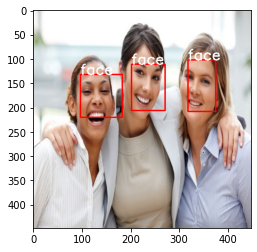

In [15]:
new_img = bounding_box_show(result, im1)
plt.imshow(new_img)

## crop the face portion for the face mask classification

convert rectangular image into square

In [16]:
def crop_face(boxes, img):
  result = []
  for box in boxes:
    y = [box[1]-1/2*box[3],box[1]+1/2*box[3]]
    x = [box[0]-1/2*box[2],box[0]+1/2*box[2]]
    crop = img[int(y[0]):int(y[1]),int(x[0]):int(x[1])]
    result.append(crop)
  return result

def resize_image(images, length):
  result = []
  for image in images:
    image = Image.fromarray(image)
    if image.size[0] < image.size[1]:
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))

        # Amount of pixel to lose in total on the height of the image.
        required_loss = (resized_image.size[1] - length)

        # Crop the height of the image so as to keep the center part.
        resized_image = resized_image.crop(
            box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))

        # We now have a length*length pixels image.
        result.append(resized_image)
    else:
        # This image is in landscape mode or already squared. The width is bigger than the heihgt.

        # This makes the height fit the LENGTH in pixels while conserving the ration.
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))

        # Amount of pixel to lose in total on the width of the image.
        required_loss = resized_image.size[0] - length

        # Crop the width of the image so as to keep 1080 pixels of the center part.
        resized_image = resized_image.crop(
            box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))

        # We now have a length*length pixels image.
        result.append(resized_image)
  return result

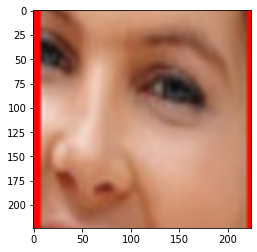

In [17]:
croped_images = crop_face(result, im1)
resized_images = resize_image(croped_images, 224)
plt.imshow(resized_images[2])

# ALEXNET classifier

## download data

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AigV8d7mGnZ9MMZyXOX0")
project = rf.workspace().project("facemask-vzqch")
dataset = project.version(3).download("folder")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to facemask-3 in folder:: 100%|██████████| 4053/4053 [00:00<00:00, 6003.23it/s]


## data preprocessing

In [ ]:
import os
import matplotlib.pyplot as plt
havemask = os.listdir('/content/facemask-3/train/have_mask')
nomask = os.listdir('/content/facemask-3/train/no_mask')
havemask.sort()
nomask.sort()
x_train = []
y_train = []
for file in havemask:
  img_path = os.path.join('/content/facemask-3/train/have_mask',file)
  img = plt.imread(img_path)
  x_train.append(img)
  y_train.append(1)
for file in nomask:
  img_path = os.path.join('/content/facemask-3/train/no_mask',file)
  img = plt.imread(img_path)
  x_train.append(img)
  y_train.append(0)

In [ ]:
havemask = os.listdir('/content/facemask-3/valid/have_mask')
nomask = os.listdir('/content/facemask-3/valid/no_mask')
x_val = []
y_val = []
havemask.sort()
nomask.sort()
for file in havemask:
  img_path = os.path.join('/content/facemask-3/valid/have_mask',file)
  img = plt.imread(img_path)
  x_val.append(img)
  y_val.append(1)
for file in nomask:
  img_path = os.path.join('/content/facemask-3/valid/no_mask',file)
  img = plt.imread(img_path)
  x_val.append(img)
  y_val.append(0)

In [ ]:
import numpy as np
x_train = np.array(x_train).astype('float32') / 255.
x_val = np.array(x_val).astype('float32') / 255.

convert the label into the one-hot encoding form 

[no_mask, have_mask]

In [ ]:
y_val = np_utils.to_categorical(y_val,2)
y_train = np_utils.to_categorical(y_train,2)

shuffle the data

In [ ]:
def shuffle(x, y):
  for i in range(x.shape[0]):
    index = np.random.randint(x.shape[0])
    current_x = x[i]
    x[i] = x[index]
    x[index] = current_x
    current_y = y[i]
    y[i] = y[index]
    y[index] = current_y
  return x, y

In [ ]:
shuffled_x_train, shuffled_y_train = shuffle(x_train, y_train)
shuffled_x_val, shuffled_y_val = shuffle(x_val, y_val)

[0. 1.]


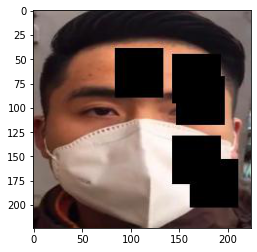

In [ ]:
plt.imshow(shuffled_x_train[2])
print(shuffled_y_train[2])

## construction of AlexNet model

In [ ]:
img_size = 224
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(img_size,img_size,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(img_size,img_size,3)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()
AlexNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics = 'accuracy')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization_9 (Batc  (None, 56, 56, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 256)     

## training

In [ ]:
history = AlexNet.fit(shuffled_x_train, shuffled_y_train,
                epochs=40,
                batch_size=128,
                shuffle=False,              
                validation_data=(shuffled_x_val, shuffled_y_val))

Epoch 1/40
31/31 [==============================] - 5s 113ms/step - loss: 0.4405 - accuracy: 0.8692 - val_loss: 5.0393 - val_accuracy: 0.1931
Epoch 2/40
31/31 [==============================] - 3s 102ms/step - loss: 0.3255 - accuracy: 0.9515 - val_loss: 0.2826 - val_accuracy: 0.9103
Epoch 3/40
31/31 [==============================] - 3s 101ms/step - loss: 0.2793 - accuracy: 0.9715 - val_loss: 0.3370 - val_accuracy: 0.8897
Epoch 4/40
31/31 [==============================] - 3s 100ms/step - loss: 0.2465 - accuracy: 0.9862 - val_loss: 0.3572 - val_accuracy: 0.8897
Epoch 5/40
31/31 [==============================] - 3s 101ms/step - loss: 0.2298 - accuracy: 0.9882 - val_loss: 0.3692 - val_accuracy: 0.8966
Epoch 6/40
31/31 [==============================] - 3s 100ms/step - loss: 0.2108 - accuracy: 0.9918 - val_loss: 0.3727 - val_accuracy: 0.9103
Epoch 7/40
31/31 [==============================] - 3s 101ms/step - loss: 0.1950 - accuracy: 0.9949 - val_loss: 0.2727 - val_accuracy: 0.9793
Epoch 

KeyboardInterrupt: ignored

## learning curve

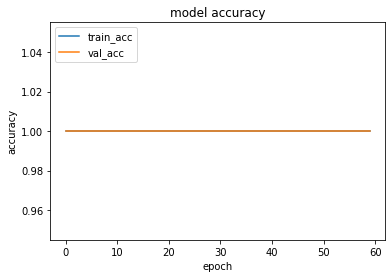

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()

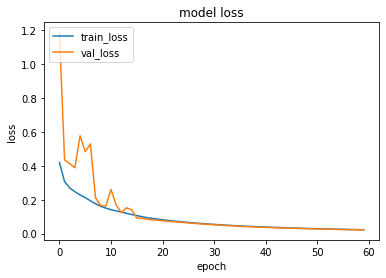

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

## save and load model

In [ ]:
AlexNet.save('/content/saved_models/AlexNet.h5')

In [18]:
classifier = load_model("/content/drive/MyDrive/saved_models/AlexNet.h5")

In [ ]:
scores = classifier.evaluate(x_val, y_val, verbose=0)
print("ACC: %.2f%%" % (scores[1]*100))

ACC: 100.00%


In [21]:
def softmax2label(prediction):
  max_value = 0
  max_index = 0
  for index, value in enumerate(prediction):
    if value>max_value: 
      max_index = index
      max_value = value
  return max_index

num2label = {1:'face_mask',0:'no_facemask!'}

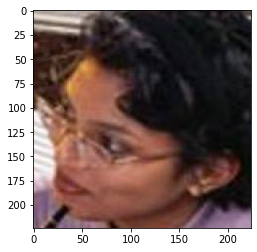

The prediction result is <<<no_facemask!>>>






In [ ]:
import matplotlib.pyplot as plt
# making prediction

img = plt.imread("/content/facemask-3/valid/no_mask/123_jpg.rf.f0c4688463ab98d2ecf01265b331693a.jpg")
pred_img = np.array(img)
plt.figure(figsize=(20, 4))
plt.imshow(pred_img)
plt.show()
#print prediction result
print('The prediction result is <<<{}>>>\n\n\n\n'.format(num2label.get(softmax2label(classifier.predict(pred_img.reshape(1,224,224,3))[0]))))

# the two-stages model

## image prediction

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[tensor([236.8049, 158.8148,  69.0816,  95.0142,  62.7813], device='cuda:0',
       grad_fn=<AbsBackward0>), tensor([140.5558, 176.3787,  85.1710,  88.2140,  51.5757], device='cuda:0',
       grad_fn=<AbsBackward0>), tensor([347.1081, 155.4171,  57.0694, 105.2128,  45.6868], device='cuda:0',
       grad_fn=<AbsBackward0>)]
-------------------------------------------------------
the prediction result is :<<['no_facemask!', 'no_facemask!', 'no_facemask!']>>
-------------------------------------------------------
[tensor([236.8049, 158.8148,  69.0816,  95.0142,  62.7813], device='cuda:0',
       grad_fn=<AbsBackward0>), tensor([140.5558, 176.3787,  85.1710,  88.2140,  51.5757], device='cuda:0',
       grad_fn=<AbsBackward0>), tensor([347.1081, 155.4171,  57.0694, 105.2128,  45.6868], device='cuda:0',
       grad_fn=<AbsBackward0>)]


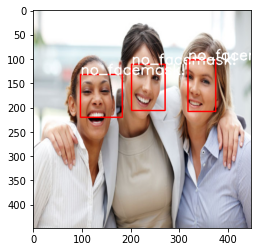

In [22]:

def crop_face(boxes, img):
  result = []
  for box in boxes:
    y = [box[1]-1/2*box[3],box[1]+1/2*box[3]]
    x = [box[0]-1/2*box[2],box[0]+1/2*box[2]]
    crop = img[int(y[0]):int(y[1]),int(x[0]):int(x[1])]
    result.append(crop)
  return result

def resize_image(images, length):
  result = []
  for image in images:
    image = Image.fromarray(image)
    if image.size[0] < image.size[1]:
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))
        required_loss = (resized_image.size[1] - length)
        resized_image = resized_image.crop(
            box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))
        result.append(resized_image)
    else:
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))
        required_loss = resized_image.size[0] - length
        resized_image = resized_image.crop(
            box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))
        result.append(resized_image)
  return result

def bounding_box_show(boxes, image, prediction_label):
  for index, box in enumerate(boxes):
    left_top_x = int(box[0]-box[2]/2)
    left_top_y = int(box[1]+box[3]/2)
    right_bottom_x = int(box[0]+box[2]/2)
    right_bottom_y = int(box[1]-box[3]/2)
    left = [left_top_x, left_top_y]
    right = [right_bottom_x, right_bottom_y]
    color = (255, 0, 0) 
    thickness = 2
    image = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
    image = cv2.putText(image,prediction_label[index],(left[0],right[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness)
  return image

def one_stop(file_path):
  #detection
  im1 = plt.imread(file_path)
  im1 = cv2.resize(im1, (448,448))
  tensor_im1 =torchvision.transforms.ToTensor()(im1)
  tensor_im1 = tensor_im1.resize(1,tensor_im1.shape[0],tensor_im1.shape[1],tensor_im1.shape[2]).float().cuda()
  result = predict(tensor_im1)
  for i in range(len(result)):
    result[i] = abs(oversize(result[i]))
  print(result)
  #resize
  croped_images = crop_face(result, im1)
  resized_images = resize_image(croped_images, 224)
  #classification
  prediction = []
  for img in resized_images:  
    pred_img = np.array(img)
    label = num2label.get(softmax2label(classifier.predict(pred_img.reshape(1,224,224,3))[0]))
    prediction.append(label)
  final_result = bounding_box_show(result, im1, prediction)
  print("-------------------------------------------------------")
  print("the prediction result is :<<{}>>".format(prediction))
  print("-------------------------------------------------------")
  plt.imshow(final_result)
  print(result)
one_stop("/content/three-women.jpg")

# real-time prediction

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## start prediction

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


KeyboardInterrupt: ignored

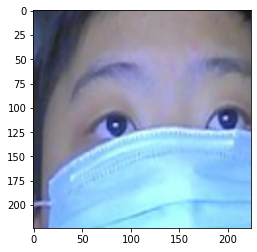

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
height_ratio = 640/448
width_ratio =  480/448

def softmax2label(prediction):
  max_value = 0
  max_index = 0
  for index, value in enumerate(prediction):
    if value>max_value: 
      max_index = index
      max_value = value
  return max_index

num2label = {1:'face_mask',0:'no_facemask!'}
def bounding_box_show(boxes, image, prediction_label):
  for index, box in enumerate(boxes):
    left_top_x = int(box[0]-box[2]/2)
    left_top_y = int(box[1]+box[3]/2)
    right_bottom_x = int(box[0]+box[2]/2)
    right_bottom_y = int(box[1]-box[3]/2)
    left = [left_top_x, left_top_y]
    right = [right_bottom_x, right_bottom_y]
    color = (255, 0, 0) 
    thickness = 2
    image = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
    image = cv2.putText(image,prediction_label[index],(left[0],right[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness)
  return image

def oversize(result, img_size= 448):
    result = abs(result)
    if result[0] >=img_size:
      result[0] = img_size-1
    elif result[0] <=0:
      result[0] = 1
    if result[1] >=img_size:
      result[1] = img_size-1
    elif result[1] <=0:
      result[1] = 1
    if result[0] + result[2] >=img_size:
      if img_size-result[0] <=0:
        result[2] = 0
      else:
        result[2] = img_size-result[0]
    if result[1] + result[3] >=img_size:
      if img_size-result[1] <=0:
        result[3] = 0
      else:
        result[3] = img_size-result[0]
    return abs(result)

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    original_img =  np.array(frame)
    im1 = cv2.resize(original_img, (448,448))
    tensor_im1 =torchvision.transforms.ToTensor()(im1)
    tensor_im1 = tensor_im1.resize(1,tensor_im1.shape[0],tensor_im1.shape[1],tensor_im1.shape[2]).float().cuda()
    result = predict(tensor_im1)
    if result == []:
      continue
    for i in range(len(result)):
      result[i] = oversize(result[i])
    croped_images = crop_face(result, im1)
    resized_images = resize_image(croped_images, 224)
    prediction = []
    for img in resized_images:  
      pred_img = np.array(img)
      plt.imshow(pred_img)
      label = num2label.get(softmax2label(classifier.predict(pred_img.reshape(1,224,224,3))[0]))
      prediction.append(label)
    for i in range(len(result)):
      result[i][1] *= width_ratio
      result[i][3] *= width_ratio
      result[i][0] *= height_ratio
      result[i][2] *= height_ratio
    bbox_array = bounding_box_show(boxes = result, image = bbox_array, prediction_label=prediction)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes